Convolutional Dictionary Learning with Spatial Mask
===================================================

This example demonstrates the use of [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn) for convolutional dictionary learning with a spatial mask, from a set of colour training images [[30]](http://sporco.rtfd.org/en/latest/zreferences.html#wohlberg-2016-convolutional). The dictionary learning algorithm is based on the hybrid mask decoupling / ADMM consensus dictionary update [[15]](http://sporco.rtfd.org/en/latest/zreferences.html#garcia-2017-convolutional).

In [1]:
from __future__ import print_function
from builtins import input
from builtins import range

import pyfftw   # See https://github.com/pyFFTW/pyFFTW/issues/40
import numpy as np

from sporco.admm import tvl2
from sporco.admm import cbpdndl
from sporco import util
from sporco import plot
plot.config_notebook_plotting()

Load training images.

In [2]:
exim = util.ExampleImages(scaled=True, zoom=0.25)
S1 = exim.image('barbara.png', idxexp=np.s_[10:522, 100:612])
S2 = exim.image('kodim23.png', idxexp=np.s_[:, 60:572])
S = np.stack((S1, S2), axis=3)

Construct initial dictionary.

In [3]:
np.random.seed(12345)
D0 = np.random.randn(8, 8, 3, 32)

Create random mask and apply to training images.

In [4]:
t = 0.5
W = np.random.randn(*(S.shape[0:3] + (1,)))
W[np.abs(W) > t] = 1;
W[np.abs(W) < t] = 0;
Sw = W * S

$\ell_2$-TV denoising with a spatial mask as a non-linear lowpass filter.

In [5]:
lmbda = 0.1
opt = tvl2.TVL2Denoise.Options({'Verbose': False, 'MaxMainIter': 200,
            'DFidWeight': W, 'gEvalY': False, 'AutoRho': {'Enabled': True}})
b = tvl2.TVL2Denoise(Sw, lmbda, opt, caxis=2)
sl = b.solve()
sh = Sw - sl

CDL without a spatial mask using [admm.cbpdndl.ConvBPDNDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNDictLearn). (Note that [parcnsdl.ConvBPDNMaskDcplDictLearn_Consensus](http://sporco.rtfd.org/en/latest/sporco.admm.parcnsdl.html#sporco.admm.parcnsdl.ConvBPDNMaskDcplDictLearn_Consensus) solves the same problem, but is substantially faster on a multi-core architecture.)

In [6]:
lmbda = 0.05
opt1 = cbpdndl.ConvBPDNDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 50.0*lmbda + 0.5},
            'CCMOD': {'rho': 3e2}})
d1 = cbpdndl.ConvBPDNDictLearn(D0, sh, lmbda, opt1)
D1 = d1.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  1.04e+03  1.24e+02  1.83e+04  1.13e-15  3.28e-01  2.05e+00  3.00e+00  4.43e-02  2.19e-01  3.00e+02


   1  9.18e+02  1.02e+02  1.63e+04  1.33e-15  1.82e-01  6.78e-01  3.00e+00  4.71e-02  3.28e-01  3.00e+02


   2  8.47e+02  7.26e+01  1.55e+04  1.18e-15  1.35e-01  4.87e-01  3.00e+00  3.07e-02  2.49e-01  3.00e+02


   3  8.07e+02  5.18e+01  1.51e+04  1.50e-15  1.04e-01  4.05e-01  3.00e+00  2.22e-02  2.04e-01  3.00e+02


   4  7.80e+02  5.80e+01  1.44e+04  1.51e-15  8.32e-02  3.43e-01  3.00e+00  1.81e-02  1.78e-01  3.00e+02


   5  7.58e+02  4.97e+01  1.42e+04  1.63e-15  6.70e-02  2.97e-01  3.00e+00  1.46e-02  1.61e-01  3.00e+02


   6  7.39e+02  4.61e+01  1.39e+04  1.42e-15  5.53e-02  2.67e-01  3.00e+00  1.20e-02  1.43e-01  3.00e+02


   7  7.24e+02  4.65e+01  1.36e+04  1.51e-15  4.63e-02  2.43e-01  3.00e+00  1.03e-02  1.27e-01  3.00e+02


   8  7.12e+02  4.49e+01  1.33e+04  1.29e-15  3.90e-02  2.21e-01  3.00e+00  8.77e-03  1.16e-01  3.00e+02


   9  7.02e+02  4.32e+01  1.32e+04  1.57e-15  3.33e-02  2.03e-01  3.00e+00  7.63e-03  1.05e-01  3.00e+02


  10  6.92e+02  4.25e+01  1.30e+04  1.72e-15  2.88e-02  1.88e-01  3.00e+00  6.68e-03  9.65e-02  3.00e+02


  11  6.85e+02  4.19e+01  1.29e+04  1.65e-15  2.51e-02  1.75e-01  3.00e+00  5.98e-03  8.91e-02  3.00e+02


  12  6.78e+02  4.13e+01  1.27e+04  1.36e-15  2.22e-02  1.63e-01  3.00e+00  5.37e-03  8.30e-02  3.00e+02


  13  6.72e+02  4.07e+01  1.26e+04  1.52e-15  1.98e-02  1.53e-01  3.00e+00  4.91e-03  7.75e-02  3.00e+02


  14  6.66e+02  4.02e+01  1.25e+04  1.34e-15  1.78e-02  1.44e-01  3.00e+00  4.51e-03  7.29e-02  3.00e+02


  15  6.61e+02  3.98e+01  1.24e+04  1.19e-15  1.62e-02  1.36e-01  3.00e+00  4.19e-03  6.88e-02  3.00e+02


  16  6.57e+02  3.94e+01  1.24e+04  1.08e-15  1.49e-02  1.29e-01  3.00e+00  3.93e-03  6.54e-02  3.00e+02


  17  6.53e+02  3.92e+01  1.23e+04  1.45e-15  1.37e-02  1.22e-01  3.00e+00  3.70e-03  6.24e-02  3.00e+02


  18  6.49e+02  3.88e+01  1.22e+04  1.36e-15  1.27e-02  1.16e-01  3.00e+00  3.51e-03  5.98e-02  3.00e+02


  19  6.46e+02  3.85e+01  1.22e+04  1.35e-15  1.19e-02  1.11e-01  3.00e+00  3.34e-03  5.74e-02  3.00e+02


  20  6.43e+02  3.83e+01  1.21e+04  1.31e-15  1.12e-02  1.06e-01  3.00e+00  3.20e-03  5.52e-02  3.00e+02


  21  6.40e+02  3.81e+01  1.20e+04  1.14e-15  1.06e-02  1.02e-01  3.00e+00  3.07e-03  5.32e-02  3.00e+02


  22  6.38e+02  3.78e+01  1.20e+04  1.26e-15  9.99e-03  9.76e-02  3.00e+00  2.96e-03  5.15e-02  3.00e+02


  23  6.35e+02  3.76e+01  1.20e+04  1.37e-15  9.49e-03  9.39e-02  3.00e+00  2.85e-03  4.99e-02  3.00e+02


  24  6.33e+02  3.74e+01  1.19e+04  1.28e-15  9.04e-03  9.05e-02  3.00e+00  2.76e-03  4.84e-02  3.00e+02


  25  6.31e+02  3.72e+01  1.19e+04  1.74e-15  8.64e-03  8.74e-02  3.00e+00  2.68e-03  4.71e-02  3.00e+02


  26  6.29e+02  3.70e+01  1.18e+04  1.61e-15  8.28e-03  8.44e-02  3.00e+00  2.60e-03  4.58e-02  3.00e+02


  27  6.27e+02  3.68e+01  1.18e+04  1.41e-15  7.95e-03  8.17e-02  3.00e+00  2.54e-03  4.47e-02  3.00e+02


  28  6.25e+02  3.67e+01  1.18e+04  1.41e-15  7.65e-03  7.91e-02  3.00e+00  2.48e-03  4.36e-02  3.00e+02


  29  6.23e+02  3.65e+01  1.17e+04  1.39e-15  7.36e-03  7.68e-02  3.00e+00  2.41e-03  4.25e-02  3.00e+02


  30  6.20e+02  3.63e+01  1.17e+04  1.50e-15  1.37e-02  7.36e-02  1.50e+00  3.47e-03  4.43e-02  3.00e+02


  31  6.18e+02  3.54e+01  1.16e+04  1.69e-15  1.33e-02  6.96e-02  1.50e+00  3.13e-03  4.67e-02  3.00e+02


  32  6.16e+02  3.51e+01  1.16e+04  1.47e-15  1.29e-02  6.57e-02  1.50e+00  3.51e-03  4.76e-02  3.00e+02


  33  6.13e+02  3.54e+01  1.16e+04  1.81e-15  1.24e-02  6.25e-02  1.50e+00  3.23e-03  4.70e-02  3.00e+02


  34  6.11e+02  3.55e+01  1.15e+04  1.28e-15  1.19e-02  5.95e-02  1.50e+00  3.32e-03  4.60e-02  3.00e+02


  35  6.10e+02  3.52e+01  1.15e+04  1.80e-15  1.14e-02  5.68e-02  1.50e+00  3.10e-03  4.49e-02  3.00e+02


  36  6.08e+02  3.50e+01  1.15e+04  1.75e-15  1.09e-02  5.44e-02  1.50e+00  3.10e-03  4.39e-02  3.00e+02


  37  6.06e+02  3.50e+01  1.14e+04  1.26e-15  1.04e-02  5.23e-02  1.50e+00  2.96e-03  4.31e-02  3.00e+02


  38  6.05e+02  3.49e+01  1.14e+04  1.43e-15  9.95e-03  5.04e-02  1.50e+00  2.93e-03  4.23e-02  3.00e+02


  39  6.03e+02  3.48e+01  1.14e+04  1.57e-15  9.54e-03  4.85e-02  1.50e+00  2.82e-03  4.16e-02  3.00e+02


  40  6.02e+02  3.46e+01  1.13e+04  1.36e-15  9.17e-03  4.69e-02  1.50e+00  2.77e-03  4.09e-02  3.00e+02


  41  6.00e+02  3.45e+01  1.13e+04  1.44e-15  8.83e-03  4.54e-02  1.50e+00  2.69e-03  4.03e-02  3.00e+02


  42  5.99e+02  3.44e+01  1.13e+04  1.45e-15  8.52e-03  4.41e-02  1.50e+00  2.64e-03  3.97e-02  3.00e+02


  43  5.98e+02  3.43e+01  1.13e+04  1.28e-15  8.24e-03  4.29e-02  1.50e+00  2.57e-03  3.92e-02  3.00e+02


  44  5.97e+02  3.42e+01  1.12e+04  1.29e-15  7.98e-03  4.17e-02  1.50e+00  2.53e-03  3.87e-02  3.00e+02


  45  5.95e+02  3.41e+01  1.12e+04  1.36e-15  7.74e-03  4.07e-02  1.50e+00  2.47e-03  3.82e-02  3.00e+02


  46  5.94e+02  3.40e+01  1.12e+04  1.27e-15  7.52e-03  3.97e-02  1.50e+00  2.43e-03  3.77e-02  3.00e+02


  47  5.93e+02  3.39e+01  1.12e+04  1.32e-15  7.32e-03  3.87e-02  1.50e+00  2.39e-03  3.72e-02  3.00e+02


  48  5.92e+02  3.38e+01  1.12e+04  1.40e-15  7.13e-03  3.78e-02  1.50e+00  2.36e-03  3.68e-02  3.00e+02


  49  5.91e+02  3.37e+01  1.11e+04  1.56e-15  6.96e-03  3.70e-02  1.50e+00  2.32e-03  3.63e-02  3.00e+02


  50  5.90e+02  3.37e+01  1.11e+04  1.54e-15  6.80e-03  3.63e-02  1.50e+00  2.28e-03  3.59e-02  3.00e+02


  51  5.89e+02  3.36e+01  1.11e+04  1.26e-15  6.66e-03  3.56e-02  1.50e+00  2.25e-03  3.55e-02  3.00e+02


  52  5.88e+02  3.35e+01  1.11e+04  1.65e-15  6.53e-03  3.49e-02  1.50e+00  2.22e-03  3.51e-02  3.00e+02


  53  5.86e+02  3.34e+01  1.11e+04  1.56e-15  6.40e-03  3.44e-02  1.50e+00  2.19e-03  3.47e-02  3.00e+02


  54  5.85e+02  3.33e+01  1.10e+04  1.57e-15  6.29e-03  3.38e-02  1.50e+00  2.17e-03  3.43e-02  3.00e+02


  55  5.84e+02  3.33e+01  1.10e+04  1.47e-15  6.18e-03  3.33e-02  1.50e+00  2.14e-03  3.39e-02  3.00e+02


  56  5.83e+02  3.32e+01  1.10e+04  1.13e-15  6.09e-03  3.29e-02  1.50e+00  2.12e-03  3.35e-02  3.00e+02


  57  5.82e+02  3.32e+01  1.10e+04  1.51e-15  6.00e-03  3.25e-02  1.50e+00  2.09e-03  3.32e-02  3.00e+02


  58  5.81e+02  3.31e+01  1.10e+04  1.60e-15  5.92e-03  3.21e-02  1.50e+00  2.07e-03  3.28e-02  3.00e+02


  59  5.80e+02  3.30e+01  1.09e+04  1.55e-15  5.84e-03  3.18e-02  1.50e+00  2.05e-03  3.25e-02  3.00e+02


  60  5.79e+02  3.30e+01  1.09e+04  1.33e-15  5.77e-03  3.14e-02  1.50e+00  2.03e-03  3.21e-02  3.00e+02


  61  5.78e+02  3.29e+01  1.09e+04  1.63e-15  5.70e-03  3.11e-02  1.50e+00  2.01e-03  3.18e-02  3.00e+02


  62  5.77e+02  3.28e+01  1.09e+04  1.33e-15  5.64e-03  3.08e-02  1.50e+00  1.99e-03  3.15e-02  3.00e+02


  63  5.76e+02  3.28e+01  1.09e+04  1.45e-15  5.58e-03  3.06e-02  1.50e+00  1.97e-03  3.13e-02  3.00e+02


  64  5.75e+02  3.28e+01  1.09e+04  1.35e-15  5.53e-03  3.03e-02  1.50e+00  1.96e-03  3.10e-02  3.00e+02


  65  5.74e+02  3.27e+01  1.08e+04  1.77e-15  5.48e-03  3.01e-02  1.50e+00  1.94e-03  3.07e-02  3.00e+02


  66  5.73e+02  3.27e+01  1.08e+04  1.27e-15  5.43e-03  2.98e-02  1.50e+00  1.93e-03  3.05e-02  3.00e+02


  67  5.73e+02  3.26e+01  1.08e+04  1.41e-15  5.39e-03  2.96e-02  1.50e+00  1.92e-03  3.02e-02  3.00e+02


  68  5.72e+02  3.25e+01  1.08e+04  1.26e-15  5.34e-03  2.94e-02  1.50e+00  1.90e-03  3.00e-02  3.00e+02


  69  5.71e+02  3.25e+01  1.08e+04  1.77e-15  5.30e-03  2.92e-02  1.50e+00  1.89e-03  2.98e-02  3.00e+02


  70  5.70e+02  3.25e+01  1.07e+04  1.64e-15  5.26e-03  2.90e-02  1.50e+00  1.88e-03  2.96e-02  3.00e+02


  71  5.69e+02  3.24e+01  1.07e+04  1.10e-15  5.23e-03  2.89e-02  1.50e+00  1.87e-03  2.94e-02  3.00e+02


  72  5.68e+02  3.24e+01  1.07e+04  1.60e-15  5.21e-03  2.88e-02  1.50e+00  1.86e-03  2.92e-02  3.00e+02


  73  5.67e+02  3.23e+01  1.07e+04  1.35e-15  5.19e-03  2.87e-02  1.50e+00  1.85e-03  2.90e-02  3.00e+02


  74  5.66e+02  3.23e+01  1.07e+04  1.54e-15  5.17e-03  2.86e-02  1.50e+00  1.84e-03  2.88e-02  3.00e+02


  75  5.65e+02  3.22e+01  1.07e+04  1.43e-15  5.15e-03  2.85e-02  1.50e+00  1.83e-03  2.87e-02  3.00e+02


  76  5.64e+02  3.22e+01  1.06e+04  1.29e-15  5.13e-03  2.84e-02  1.50e+00  1.82e-03  2.85e-02  3.00e+02


  77  5.63e+02  3.21e+01  1.06e+04  1.55e-15  5.12e-03  2.84e-02  1.50e+00  1.82e-03  2.83e-02  3.00e+02


  78  5.63e+02  3.21e+01  1.06e+04  1.58e-15  5.11e-03  2.83e-02  1.50e+00  1.81e-03  2.82e-02  3.00e+02


  79  5.62e+02  3.21e+01  1.06e+04  1.45e-15  5.11e-03  2.83e-02  1.50e+00  1.81e-03  2.80e-02  3.00e+02


  80  5.61e+02  3.20e+01  1.06e+04  2.01e-15  5.10e-03  2.82e-02  1.50e+00  1.80e-03  2.79e-02  3.00e+02


  81  5.60e+02  3.20e+01  1.06e+04  1.35e-15  5.09e-03  2.82e-02  1.50e+00  1.79e-03  2.77e-02  3.00e+02


  82  5.59e+02  3.20e+01  1.05e+04  1.29e-15  5.08e-03  2.81e-02  1.50e+00  1.79e-03  2.76e-02  3.00e+02


  83  5.58e+02  3.19e+01  1.05e+04  1.97e-15  5.07e-03  2.81e-02  1.50e+00  1.79e-03  2.74e-02  3.00e+02


  84  5.57e+02  3.19e+01  1.05e+04  1.54e-15  5.07e-03  2.80e-02  1.50e+00  1.78e-03  2.73e-02  3.00e+02


  85  5.56e+02  3.19e+01  1.05e+04  1.34e-15  5.06e-03  2.79e-02  1.50e+00  1.78e-03  2.72e-02  3.00e+02


  86  5.55e+02  3.18e+01  1.05e+04  1.19e-15  5.05e-03  2.79e-02  1.50e+00  1.77e-03  2.71e-02  3.00e+02


  87  5.54e+02  3.18e+01  1.05e+04  1.47e-15  5.05e-03  2.79e-02  1.50e+00  1.77e-03  2.69e-02  3.00e+02


  88  5.54e+02  3.18e+01  1.04e+04  1.69e-15  5.04e-03  2.78e-02  1.50e+00  1.76e-03  2.68e-02  3.00e+02


  89  5.53e+02  3.18e+01  1.04e+04  1.15e-15  5.04e-03  2.78e-02  1.50e+00  1.76e-03  2.67e-02  3.00e+02


  90  5.52e+02  3.17e+01  1.04e+04  1.47e-15  5.03e-03  2.78e-02  1.50e+00  1.75e-03  2.66e-02  3.00e+02


  91  5.51e+02  3.17e+01  1.04e+04  1.40e-15  5.03e-03  2.77e-02  1.50e+00  1.75e-03  2.65e-02  3.00e+02


  92  5.50e+02  3.17e+01  1.04e+04  1.64e-15  5.02e-03  2.77e-02  1.50e+00  1.75e-03  2.64e-02  3.00e+02


  93  5.49e+02  3.17e+01  1.04e+04  1.39e-15  5.02e-03  2.77e-02  1.50e+00  1.74e-03  2.63e-02  3.00e+02


  94  5.48e+02  3.17e+01  1.03e+04  1.45e-15  5.01e-03  2.76e-02  1.50e+00  1.74e-03  2.62e-02  3.00e+02


  95  5.47e+02  3.16e+01  1.03e+04  1.76e-15  5.01e-03  2.76e-02  1.50e+00  1.74e-03  2.61e-02  3.00e+02


  96  5.47e+02  3.16e+01  1.03e+04  1.54e-15  5.00e-03  2.75e-02  1.50e+00  1.73e-03  2.60e-02  3.00e+02


  97  5.46e+02  3.16e+01  1.03e+04  1.48e-15  5.00e-03  2.75e-02  1.50e+00  1.73e-03  2.59e-02  3.00e+02


  98  5.45e+02  3.16e+01  1.03e+04  1.13e-15  4.99e-03  2.75e-02  1.50e+00  1.73e-03  2.58e-02  3.00e+02


  99  5.44e+02  3.16e+01  1.03e+04  1.23e-15  4.99e-03  2.74e-02  1.50e+00  1.72e-03  2.57e-02  3.00e+02


 100  5.43e+02  3.16e+01  1.02e+04  1.38e-15  4.98e-03  2.74e-02  1.50e+00  1.72e-03  2.56e-02  3.00e+02


 101  5.42e+02  3.15e+01  1.02e+04  1.05e-15  4.98e-03  2.73e-02  1.50e+00  1.72e-03  2.54e-02  3.00e+02


 102  5.42e+02  3.15e+01  1.02e+04  1.74e-15  4.97e-03  2.73e-02  1.50e+00  1.71e-03  2.53e-02  3.00e+02


 103  5.41e+02  3.15e+01  1.02e+04  1.46e-15  4.97e-03  2.72e-02  1.50e+00  1.71e-03  2.52e-02  3.00e+02


 104  5.40e+02  3.15e+01  1.02e+04  1.46e-15  4.96e-03  2.72e-02  1.50e+00  1.70e-03  2.51e-02  3.00e+02


 105  5.39e+02  3.15e+01  1.02e+04  1.60e-15  4.95e-03  2.71e-02  1.50e+00  1.70e-03  2.50e-02  3.00e+02


 106  5.38e+02  3.15e+01  1.01e+04  1.50e-15  4.95e-03  2.71e-02  1.50e+00  1.70e-03  2.50e-02  3.00e+02


 107  5.38e+02  3.15e+01  1.01e+04  1.34e-15  4.94e-03  2.70e-02  1.50e+00  1.69e-03  2.49e-02  3.00e+02


 108  5.37e+02  3.15e+01  1.01e+04  1.91e-15  4.94e-03  2.70e-02  1.50e+00  1.69e-03  2.48e-02  3.00e+02


 109  5.36e+02  3.15e+01  1.01e+04  1.28e-15  4.93e-03  2.70e-02  1.50e+00  1.69e-03  2.47e-02  3.00e+02


 110  5.35e+02  3.15e+01  1.01e+04  1.41e-15  4.93e-03  2.69e-02  1.50e+00  1.68e-03  2.46e-02  3.00e+02


 111  5.35e+02  3.15e+01  1.01e+04  1.44e-15  4.92e-03  2.69e-02  1.50e+00  1.68e-03  2.45e-02  3.00e+02


 112  5.34e+02  3.15e+01  1.00e+04  1.64e-15  4.92e-03  2.69e-02  1.50e+00  1.68e-03  2.44e-02  3.00e+02


 113  5.33e+02  3.15e+01  1.00e+04  1.65e-15  4.92e-03  2.69e-02  1.50e+00  1.67e-03  2.43e-02  3.00e+02


 114  5.32e+02  3.14e+01  1.00e+04  1.06e-15  4.92e-03  2.68e-02  1.50e+00  1.67e-03  2.43e-02  3.00e+02


 115  5.31e+02  3.14e+01  1.00e+04  1.59e-15  4.92e-03  2.68e-02  1.50e+00  1.67e-03  2.42e-02  3.00e+02


 116  5.31e+02  3.14e+01  9.99e+03  1.19e-15  4.92e-03  2.68e-02  1.50e+00  1.67e-03  2.41e-02  3.00e+02


 117  5.30e+02  3.14e+01  9.97e+03  1.46e-15  4.93e-03  2.68e-02  1.50e+00  1.67e-03  2.40e-02  3.00e+02


 118  5.29e+02  3.15e+01  9.95e+03  1.25e-15  4.93e-03  2.67e-02  1.50e+00  1.67e-03  2.40e-02  3.00e+02


 119  5.28e+02  3.15e+01  9.94e+03  1.39e-15  4.93e-03  2.67e-02  1.50e+00  1.66e-03  2.39e-02  3.00e+02


 120  5.28e+02  3.15e+01  9.92e+03  1.59e-15  4.93e-03  2.67e-02  1.50e+00  1.66e-03  2.38e-02  3.00e+02


 121  5.27e+02  3.15e+01  9.91e+03  1.56e-15  4.93e-03  2.67e-02  1.50e+00  1.66e-03  2.38e-02  3.00e+02


 122  5.26e+02  3.15e+01  9.90e+03  1.37e-15  4.93e-03  2.67e-02  1.50e+00  1.66e-03  2.37e-02  3.00e+02


 123  5.25e+02  3.15e+01  9.88e+03  1.63e-15  4.92e-03  2.66e-02  1.50e+00  1.66e-03  2.37e-02  3.00e+02


 124  5.25e+02  3.15e+01  9.87e+03  1.08e-15  4.92e-03  2.66e-02  1.50e+00  1.66e-03  2.36e-02  3.00e+02


 125  5.24e+02  3.15e+01  9.85e+03  1.58e-15  4.92e-03  2.66e-02  1.50e+00  1.66e-03  2.35e-02  3.00e+02


 126  5.23e+02  3.15e+01  9.84e+03  1.25e-15  4.92e-03  2.66e-02  1.50e+00  1.65e-03  2.35e-02  3.00e+02


 127  5.23e+02  3.15e+01  9.82e+03  1.35e-15  4.92e-03  2.65e-02  1.50e+00  1.65e-03  2.34e-02  3.00e+02


 128  5.22e+02  3.15e+01  9.81e+03  1.30e-15  4.92e-03  2.65e-02  1.50e+00  1.65e-03  2.34e-02  3.00e+02


 129  5.21e+02  3.15e+01  9.79e+03  1.56e-15  4.92e-03  2.64e-02  1.50e+00  1.65e-03  2.33e-02  3.00e+02


 130  5.21e+02  3.15e+01  9.78e+03  1.66e-15  4.91e-03  2.64e-02  1.50e+00  1.64e-03  2.32e-02  3.00e+02


 131  5.20e+02  3.15e+01  9.77e+03  1.49e-15  4.91e-03  2.63e-02  1.50e+00  1.64e-03  2.32e-02  3.00e+02


 132  5.19e+02  3.15e+01  9.75e+03  1.43e-15  4.90e-03  2.63e-02  1.50e+00  1.64e-03  2.31e-02  3.00e+02


 133  5.19e+02  3.16e+01  9.74e+03  1.49e-15  4.90e-03  2.63e-02  1.50e+00  1.64e-03  2.30e-02  3.00e+02


 134  5.18e+02  3.16e+01  9.73e+03  1.56e-15  4.89e-03  2.62e-02  1.50e+00  1.63e-03  2.30e-02  3.00e+02


 135  5.17e+02  3.16e+01  9.71e+03  1.33e-15  4.89e-03  2.62e-02  1.50e+00  1.63e-03  2.29e-02  3.00e+02


 136  5.17e+02  3.16e+01  9.70e+03  1.45e-15  4.89e-03  2.62e-02  1.50e+00  1.63e-03  2.29e-02  3.00e+02


 137  5.16e+02  3.16e+01  9.69e+03  1.44e-15  4.89e-03  2.62e-02  1.50e+00  1.63e-03  2.28e-02  3.00e+02


 138  5.15e+02  3.16e+01  9.67e+03  1.34e-15  4.89e-03  2.61e-02  1.50e+00  1.63e-03  2.28e-02  3.00e+02


 139  5.15e+02  3.16e+01  9.66e+03  1.60e-15  4.88e-03  2.61e-02  1.50e+00  1.63e-03  2.27e-02  3.00e+02


 140  5.14e+02  3.16e+01  9.65e+03  1.54e-15  4.88e-03  2.60e-02  1.50e+00  1.63e-03  2.27e-02  3.00e+02


 141  5.13e+02  3.17e+01  9.63e+03  1.46e-15  4.88e-03  2.60e-02  1.50e+00  1.62e-03  2.26e-02  3.00e+02


 142  5.13e+02  3.17e+01  9.62e+03  1.46e-15  4.88e-03  2.60e-02  1.50e+00  1.62e-03  2.26e-02  3.00e+02


 143  5.12e+02  3.17e+01  9.61e+03  1.12e-15  4.87e-03  2.59e-02  1.50e+00  1.62e-03  2.25e-02  3.00e+02


 144  5.12e+02  3.17e+01  9.60e+03  1.49e-15  4.86e-03  2.58e-02  1.50e+00  1.62e-03  2.24e-02  3.00e+02


 145  5.11e+02  3.17e+01  9.58e+03  1.38e-15  4.85e-03  2.58e-02  1.50e+00  1.62e-03  2.24e-02  3.00e+02


 146  5.10e+02  3.17e+01  9.57e+03  1.52e-15  4.84e-03  2.57e-02  1.50e+00  1.61e-03  2.23e-02  3.00e+02


 147  5.10e+02  3.17e+01  9.56e+03  1.60e-15  4.83e-03  2.56e-02  1.50e+00  1.61e-03  2.22e-02  3.00e+02


 148  5.09e+02  3.18e+01  9.55e+03  1.47e-15  4.82e-03  2.55e-02  1.50e+00  1.60e-03  2.22e-02  3.00e+02


 149  5.09e+02  3.18e+01  9.54e+03  1.62e-15  4.80e-03  2.54e-02  1.50e+00  1.60e-03  2.21e-02  3.00e+02


 150  5.08e+02  3.18e+01  9.52e+03  1.71e-15  4.79e-03  2.54e-02  1.50e+00  1.59e-03  2.21e-02  3.00e+02


 151  5.07e+02  3.18e+01  9.51e+03  1.35e-15  4.78e-03  2.53e-02  1.50e+00  1.59e-03  2.20e-02  3.00e+02


 152  5.07e+02  3.18e+01  9.50e+03  1.23e-15  4.77e-03  2.53e-02  1.50e+00  1.59e-03  2.20e-02  3.00e+02


 153  5.06e+02  3.18e+01  9.49e+03  1.57e-15  4.76e-03  2.52e-02  1.50e+00  1.58e-03  2.19e-02  3.00e+02


 154  5.06e+02  3.19e+01  9.48e+03  1.23e-15  4.74e-03  2.51e-02  1.50e+00  1.58e-03  2.19e-02  3.00e+02


 155  5.05e+02  3.19e+01  9.47e+03  1.23e-15  4.73e-03  2.51e-02  1.50e+00  1.58e-03  2.18e-02  3.00e+02


 156  5.05e+02  3.19e+01  9.46e+03  1.28e-15  4.73e-03  2.50e-02  1.50e+00  1.58e-03  2.18e-02  3.00e+02


 157  5.04e+02  3.19e+01  9.45e+03  1.40e-15  4.72e-03  2.49e-02  1.50e+00  1.58e-03  2.17e-02  3.00e+02


 158  5.04e+02  3.19e+01  9.44e+03  1.46e-15  4.71e-03  2.48e-02  1.50e+00  1.57e-03  2.17e-02  3.00e+02


 159  5.03e+02  3.19e+01  9.42e+03  1.43e-15  4.70e-03  2.48e-02  1.50e+00  1.57e-03  2.16e-02  3.00e+02


 160  5.03e+02  3.20e+01  9.41e+03  1.44e-15  4.69e-03  2.47e-02  1.50e+00  1.57e-03  2.16e-02  3.00e+02


 161  5.02e+02  3.20e+01  9.40e+03  1.64e-15  4.68e-03  2.46e-02  1.50e+00  1.57e-03  2.15e-02  3.00e+02


 162  5.02e+02  3.20e+01  9.39e+03  1.50e-15  4.67e-03  2.46e-02  1.50e+00  1.56e-03  2.14e-02  3.00e+02


 163  5.01e+02  3.20e+01  9.38e+03  1.48e-15  4.66e-03  2.45e-02  1.50e+00  1.56e-03  2.14e-02  3.00e+02


 164  5.01e+02  3.20e+01  9.37e+03  1.46e-15  4.65e-03  2.44e-02  1.50e+00  1.55e-03  2.13e-02  3.00e+02


 165  5.00e+02  3.21e+01  9.36e+03  1.45e-15  4.64e-03  2.44e-02  1.50e+00  1.55e-03  2.12e-02  3.00e+02


 166  5.00e+02  3.21e+01  9.35e+03  1.16e-15  4.63e-03  2.43e-02  1.50e+00  1.55e-03  2.12e-02  3.00e+02


 167  4.99e+02  3.21e+01  9.34e+03  1.26e-15  4.62e-03  2.42e-02  1.50e+00  1.54e-03  2.11e-02  3.00e+02


 168  4.99e+02  3.21e+01  9.33e+03  1.67e-15  4.61e-03  2.42e-02  1.50e+00  1.54e-03  2.11e-02  3.00e+02


 169  4.98e+02  3.21e+01  9.32e+03  1.39e-15  4.60e-03  2.41e-02  1.50e+00  1.54e-03  2.10e-02  3.00e+02


 170  4.98e+02  3.22e+01  9.31e+03  1.58e-15  4.58e-03  2.40e-02  1.50e+00  1.53e-03  2.09e-02  3.00e+02


 171  4.97e+02  3.22e+01  9.31e+03  1.51e-15  4.57e-03  2.39e-02  1.50e+00  1.53e-03  2.09e-02  3.00e+02


 172  4.97e+02  3.22e+01  9.30e+03  1.45e-15  4.56e-03  2.39e-02  1.50e+00  1.53e-03  2.08e-02  3.00e+02


 173  4.97e+02  3.22e+01  9.29e+03  1.50e-15  4.55e-03  2.38e-02  1.50e+00  1.52e-03  2.08e-02  3.00e+02


 174  4.96e+02  3.22e+01  9.28e+03  1.37e-15  4.54e-03  2.37e-02  1.50e+00  1.52e-03  2.07e-02  3.00e+02


 175  4.96e+02  3.23e+01  9.27e+03  1.41e-15  4.53e-03  2.36e-02  1.50e+00  1.51e-03  2.06e-02  3.00e+02


 176  4.95e+02  3.23e+01  9.26e+03  1.29e-15  4.51e-03  2.36e-02  1.50e+00  1.51e-03  2.06e-02  3.00e+02


 177  4.95e+02  3.23e+01  9.25e+03  1.35e-15  4.50e-03  2.35e-02  1.50e+00  1.50e-03  2.05e-02  3.00e+02


 178  4.94e+02  3.23e+01  9.24e+03  1.52e-15  4.49e-03  2.34e-02  1.50e+00  1.50e-03  2.05e-02  3.00e+02


 179  4.94e+02  3.23e+01  9.23e+03  1.26e-15  4.47e-03  2.34e-02  1.50e+00  1.50e-03  2.04e-02  3.00e+02


 180  4.94e+02  3.23e+01  9.23e+03  1.39e-15  4.46e-03  2.33e-02  1.50e+00  1.49e-03  2.04e-02  3.00e+02


 181  4.93e+02  3.24e+01  9.22e+03  1.27e-15  4.45e-03  2.33e-02  1.50e+00  1.49e-03  2.03e-02  3.00e+02


 182  4.93e+02  3.24e+01  9.21e+03  1.43e-15  4.44e-03  2.32e-02  1.50e+00  1.49e-03  2.03e-02  3.00e+02


 183  4.92e+02  3.24e+01  9.20e+03  1.38e-15  4.43e-03  2.31e-02  1.50e+00  1.48e-03  2.02e-02  3.00e+02


 184  4.92e+02  3.24e+01  9.19e+03  1.29e-15  4.42e-03  2.31e-02  1.50e+00  1.48e-03  2.01e-02  3.00e+02


 185  4.92e+02  3.24e+01  9.19e+03  1.54e-15  4.41e-03  2.30e-02  1.50e+00  1.48e-03  2.01e-02  3.00e+02


 186  4.91e+02  3.24e+01  9.18e+03  1.50e-15  4.40e-03  2.29e-02  1.50e+00  1.47e-03  2.00e-02  3.00e+02


 187  4.91e+02  3.25e+01  9.17e+03  1.38e-15  4.39e-03  2.29e-02  1.50e+00  1.47e-03  1.99e-02  3.00e+02


 188  4.91e+02  3.25e+01  9.16e+03  1.26e-15  4.37e-03  2.28e-02  1.50e+00  1.47e-03  1.99e-02  3.00e+02


 189  4.90e+02  3.25e+01  9.16e+03  1.43e-15  4.35e-03  2.27e-02  1.50e+00  1.46e-03  1.98e-02  3.00e+02


 190  4.90e+02  3.25e+01  9.15e+03  1.50e-15  4.34e-03  2.26e-02  1.50e+00  1.45e-03  1.97e-02  3.00e+02


 191  4.90e+02  3.25e+01  9.14e+03  1.30e-15  4.32e-03  2.24e-02  1.50e+00  1.45e-03  1.96e-02  3.00e+02


 192  4.89e+02  3.25e+01  9.13e+03  1.22e-15  4.29e-03  2.23e-02  1.50e+00  1.44e-03  1.96e-02  3.00e+02


 193  4.89e+02  3.26e+01  9.13e+03  1.47e-15  4.27e-03  2.22e-02  1.50e+00  1.44e-03  1.95e-02  3.00e+02


 194  4.89e+02  3.26e+01  9.12e+03  1.30e-15  4.25e-03  2.21e-02  1.50e+00  1.43e-03  1.94e-02  3.00e+02


 195  4.88e+02  3.26e+01  9.11e+03  1.58e-15  4.23e-03  2.20e-02  1.50e+00  1.43e-03  1.93e-02  3.00e+02


 196  4.88e+02  3.26e+01  9.11e+03  1.45e-15  4.21e-03  2.19e-02  1.50e+00  1.42e-03  1.92e-02  3.00e+02


 197  4.88e+02  3.26e+01  9.10e+03  1.53e-15  4.19e-03  2.18e-02  1.50e+00  1.41e-03  1.92e-02  3.00e+02


 198  4.87e+02  3.26e+01  9.10e+03  1.31e-15  4.17e-03  2.17e-02  1.50e+00  1.41e-03  1.91e-02  3.00e+02


 199  4.87e+02  3.26e+01  9.09e+03  1.40e-15  4.15e-03  2.16e-02  1.50e+00  1.40e-03  1.90e-02  3.00e+02
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution without a spatial mask.

In [7]:
sr1 = d1.reconstruct().squeeze() + sl

CDL with a spatial mask using [cbpdndl.ConvBPDNMaskDcplDictLearn](http://sporco.rtfd.org/en/latest/sporco.admm.cbpdndl.html#sporco.admm.cbpdndl.ConvBPDNMaskDcplDictLearn).

In [8]:
opt2 = cbpdndl.ConvBPDNMaskDcplDictLearn.Options({'Verbose': True,
            'MaxMainIter': 200, 'AccurateDFid': True,
            'CBPDN': {'rho': 50.0*lmbda + 0.5},
            'CCMOD': {'rho': 1.0}})
d2 = cbpdndl.ConvBPDNMaskDcplDictLearn(D0, sh, lmbda, W, opt2)
D2 = d2.solve()

Itn   Fnc       DFid      ℓ1        Cnstr     r_X       s_X       ρ_X       r_D       s_D       ρ_D       
--------------------------------------------------------------------------------------------------------


   0  1.33e+03  1.05e+02  2.44e+04  1.44e-15  1.57e-01  1.01e+00  3.00e+00  7.10e-02  2.10e+01  1.00e+00


   1  4.86e+02  2.50e+01  9.21e+03  1.21e-15  1.25e-01  9.74e-01  3.00e+00  6.35e-02  1.45e+01  1.00e+00


   2  7.22e+02  7.53e+01  1.29e+04  1.37e-15  9.15e-02  9.83e-01  3.00e+00  5.04e-02  2.01e+01  1.00e+00


   3  4.68e+02  1.59e+01  9.04e+03  1.34e-15  7.45e-02  9.58e-01  3.00e+00  5.04e-02  1.62e+01  1.00e+00


   4  4.08e+02  1.53e+01  7.85e+03  1.72e-15  5.96e-02  9.53e-01  3.00e+00  4.64e-02  1.47e+01  1.00e+00


   5  4.11e+02  1.08e+01  8.00e+03  1.47e-15  4.84e-02  9.72e-01  3.00e+00  3.74e-02  1.58e+01  1.00e+00


   6  3.58e+02  1.17e+01  6.93e+03  1.17e-15  4.05e-02  9.58e-01  3.00e+00  3.39e-02  1.54e+01  1.00e+00


   7  3.22e+02  1.38e+01  6.17e+03  1.58e-15  3.50e-02  9.33e-01  3.00e+00  3.23e-02  1.50e+01  1.00e+00


   8  3.09e+02  1.38e+01  5.89e+03  1.77e-15  3.02e-02  9.13e-01  3.00e+00  3.17e-02  1.49e+01  1.00e+00


   9  2.85e+02  1.31e+01  5.44e+03  1.65e-15  2.72e-02  8.86e-01  3.00e+00  3.27e-02  1.44e+01  1.00e+00


  10  2.59e+02  1.40e+01  4.90e+03  1.09e-15  2.44e-02  8.60e-01  3.00e+00  3.42e-02  1.39e+01  1.00e+00


  11  2.40e+02  1.49e+01  4.51e+03  1.36e-15  2.23e-02  8.42e-01  3.00e+00  3.51e-02  1.34e+01  1.00e+00


  12  2.24e+02  1.50e+01  4.19e+03  1.53e-15  2.07e-02  8.19e-01  3.00e+00  3.68e-02  1.29e+01  1.00e+00


  13  2.07e+02  1.52e+01  3.83e+03  1.45e-15  1.94e-02  7.94e-01  3.00e+00  3.92e-02  1.24e+01  1.00e+00


  14  1.90e+02  1.59e+01  3.49e+03  1.53e-15  1.82e-02  7.71e-01  3.00e+00  4.16e-02  1.18e+01  1.00e+00


  15  1.77e+02  1.63e+01  3.22e+03  1.13e-15  1.73e-02  7.52e-01  3.00e+00  4.32e-02  1.13e+01  1.00e+00


  16  1.65e+02  1.65e+01  2.97e+03  1.20e-15  1.64e-02  7.29e-01  3.00e+00  4.53e-02  1.08e+01  1.00e+00


  17  1.53e+02  1.67e+01  2.72e+03  1.16e-15  1.57e-02  7.04e-01  3.00e+00  4.75e-02  1.03e+01  1.00e+00


  18  1.42e+02  1.70e+01  2.49e+03  1.30e-15  1.49e-02  6.81e-01  3.00e+00  4.95e-02  9.73e+00  1.00e+00


  19  1.32e+02  1.73e+01  2.30e+03  1.51e-15  1.43e-02  6.60e-01  3.00e+00  5.09e-02  9.24e+00  1.00e+00


  20  1.24e+02  1.74e+01  2.13e+03  1.11e-15  1.37e-02  6.37e-01  3.00e+00  5.23e-02  8.78e+00  1.00e+00


  21  1.16e+02  1.75e+01  1.97e+03  1.79e-15  1.32e-02  6.12e-01  3.00e+00  5.39e-02  8.33e+00  1.00e+00


  22  1.09e+02  1.76e+01  1.82e+03  1.55e-15  1.26e-02  5.89e-01  3.00e+00  5.55e-02  7.88e+00  1.00e+00


  23  1.02e+02  1.76e+01  1.69e+03  1.47e-15  1.21e-02  5.68e-01  3.00e+00  5.36e-02  7.41e+00  1.00e+00


  24  9.63e+01  1.76e+01  1.58e+03  1.37e-15  1.17e-02  5.49e-01  3.00e+00  5.12e-02  6.93e+00  1.00e+00


  25  9.10e+01  1.74e+01  1.47e+03  1.42e-15  1.13e-02  5.31e-01  3.00e+00  4.94e-02  6.41e+00  1.00e+00


  26  8.60e+01  1.72e+01  1.38e+03  1.79e-15  1.10e-02  5.17e-01  3.00e+00  4.84e-02  5.80e+00  1.00e+00


  27  8.16e+01  1.71e+01  1.29e+03  1.73e-15  1.09e-02  5.07e-01  3.00e+00  4.78e-02  4.97e+00  1.00e+00


  28  7.77e+01  1.71e+01  1.21e+03  1.47e-15  1.11e-02  5.03e-01  3.00e+00  4.77e-02  3.79e+00  1.00e+00


  29  7.47e+01  1.75e+01  1.14e+03  1.29e-15  1.16e-02  5.09e-01  3.00e+00  4.80e-02  2.40e+00  1.00e+00


  30  7.30e+01  1.87e+01  1.09e+03  1.55e-15  1.30e-02  5.32e-01  3.00e+00  4.91e-02  1.85e+00  1.00e+00


  31  7.33e+01  2.09e+01  1.05e+03  1.65e-15  1.62e-02  5.82e-01  3.00e+00  5.22e-02  2.47e+00  1.00e+00


  32  7.40e+01  2.28e+01  1.02e+03  1.47e-15  2.21e-02  6.59e-01  3.00e+00  6.21e-02  3.13e+00  1.00e+00


  33  7.41e+01  2.51e+01  9.80e+02  1.58e-15  2.72e-02  7.37e-01  3.00e+00  8.04e-02  3.68e+00  1.00e+00


  34  7.00e+01  2.72e+01  8.57e+02  1.09e-15  2.97e-02  7.64e-01  3.00e+00  1.06e-01  3.47e+00  1.00e+00


  35  6.09e+01  2.65e+01  6.88e+02  1.34e-15  2.98e-02  6.92e-01  3.00e+00  1.43e-01  1.89e+00  1.00e+00


  36  5.40e+01  2.26e+01  6.28e+02  1.15e-15  2.43e-02  5.76e-01  3.00e+00  1.40e-01  1.49e+00  1.00e+00


  37  4.97e+01  1.78e+01  6.36e+02  1.44e-15  2.08e-02  4.99e-01  3.00e+00  1.26e-01  1.18e+00  1.00e+00


  38  4.70e+01  1.54e+01  6.32e+02  1.38e-15  1.87e-02  4.53e-01  3.00e+00  1.15e-01  9.68e-01  1.00e+00


  39  4.50e+01  1.49e+01  6.02e+02  1.53e-15  1.70e-02  4.18e-01  3.00e+00  1.07e-01  9.09e-01  1.00e+00


  40  4.37e+01  1.52e+01  5.70e+02  1.20e-15  1.57e-02  3.87e-01  3.00e+00  1.01e-01  8.67e-01  1.00e+00


  41  4.28e+01  1.54e+01  5.47e+02  1.52e-15  1.43e-02  3.56e-01  3.00e+00  9.70e-02  8.10e-01  1.00e+00


  42  4.17e+01  1.51e+01  5.32e+02  1.17e-15  1.27e-02  3.26e-01  3.00e+00  9.59e-02  7.43e-01  1.00e+00


  43  4.09e+01  1.47e+01  5.24e+02  1.64e-15  1.14e-02  3.01e-01  3.00e+00  8.62e-02  7.36e-01  1.00e+00


  44  4.05e+01  1.45e+01  5.20e+02  1.30e-15  1.05e-02  2.84e-01  3.00e+00  8.02e-02  7.81e-01  1.00e+00


  45  4.03e+01  1.44e+01  5.17e+02  1.70e-15  9.74e-03  2.71e-01  3.00e+00  7.51e-02  8.16e-01  1.00e+00


  46  4.01e+01  1.43e+01  5.16e+02  1.33e-15  8.89e-03  2.58e-01  3.00e+00  7.16e-02  8.20e-01  1.00e+00


  47  3.97e+01  1.38e+01  5.18e+02  1.21e-15  8.03e-03  2.45e-01  3.00e+00  6.97e-02  7.79e-01  1.00e+00


  48  3.92e+01  1.31e+01  5.22e+02  1.49e-15  7.29e-03  2.33e-01  3.00e+00  6.88e-02  6.76e-01  1.00e+00


  49  3.87e+01  1.25e+01  5.23e+02  1.54e-15  6.88e-03  2.24e-01  3.00e+00  6.71e-02  5.66e-01  1.00e+00


  50  3.84e+01  1.25e+01  5.19e+02  1.32e-15  6.76e-03  2.18e-01  3.00e+00  6.45e-02  5.95e-01  1.00e+00


  51  3.83e+01  1.27e+01  5.12e+02  1.76e-15  6.67e-03  2.13e-01  3.00e+00  6.13e-02  6.93e-01  1.00e+00


  52  3.83e+01  1.30e+01  5.06e+02  1.27e-15  6.51e-03  2.08e-01  3.00e+00  5.83e-02  7.51e-01  1.00e+00


  53  3.83e+01  1.31e+01  5.04e+02  1.27e-15  6.29e-03  2.05e-01  3.00e+00  5.62e-02  7.66e-01  1.00e+00


  54  3.83e+01  1.30e+01  5.07e+02  1.24e-15  6.01e-03  2.04e-01  3.00e+00  5.55e-02  7.48e-01  1.00e+00


  55  3.81e+01  1.26e+01  5.10e+02  1.44e-15  5.74e-03  2.03e-01  3.00e+00  5.59e-02  7.09e-01  1.00e+00


  56  3.79e+01  1.23e+01  5.12e+02  1.33e-15  5.55e-03  2.01e-01  3.00e+00  5.66e-02  6.63e-01  1.00e+00


  57  3.77e+01  1.20e+01  5.12e+02  1.20e-15  5.43e-03  1.98e-01  3.00e+00  5.60e-02  6.34e-01  1.00e+00


  58  3.75e+01  1.19e+01  5.11e+02  1.73e-15  5.39e-03  1.94e-01  3.00e+00  5.44e-02  6.27e-01  1.00e+00


  59  3.74e+01  1.19e+01  5.10e+02  1.57e-15  5.39e-03  1.90e-01  3.00e+00  5.30e-02  6.30e-01  1.00e+00


  60  3.73e+01  1.19e+01  5.07e+02  1.72e-15  5.39e-03  1.88e-01  3.00e+00  5.18e-02  6.28e-01  1.00e+00


  61  3.72e+01  1.20e+01  5.05e+02  1.56e-15  5.34e-03  1.88e-01  3.00e+00  5.10e-02  6.25e-01  1.00e+00


  62  3.71e+01  1.21e+01  5.01e+02  1.54e-15  5.22e-03  1.89e-01  3.00e+00  5.02e-02  6.31e-01  1.00e+00


  63  3.71e+01  1.22e+01  4.98e+02  1.38e-15  5.08e-03  1.89e-01  3.00e+00  4.91e-02  6.47e-01  1.00e+00


  64  3.70e+01  1.22e+01  4.96e+02  1.19e-15  4.93e-03  1.88e-01  3.00e+00  4.77e-02  6.64e-01  1.00e+00


  65  3.70e+01  1.22e+01  4.95e+02  1.19e-15  4.80e-03  1.86e-01  3.00e+00  4.52e-02  6.69e-01  1.00e+00


  66  3.69e+01  1.21e+01  4.96e+02  1.21e-15  4.66e-03  1.82e-01  3.00e+00  4.24e-02  6.55e-01  1.00e+00


  67  3.68e+01  1.19e+01  4.97e+02  1.32e-15  4.51e-03  1.78e-01  3.00e+00  4.07e-02  6.17e-01  1.00e+00


  68  3.66e+01  1.18e+01  4.97e+02  1.69e-15  4.38e-03  1.73e-01  3.00e+00  3.99e-02  5.60e-01  1.00e+00


  69  3.65e+01  1.16e+01  4.97e+02  1.40e-15  4.31e-03  1.68e-01  3.00e+00  3.96e-02  5.07e-01  1.00e+00


  70  3.64e+01  1.16e+01  4.96e+02  1.33e-15  4.33e-03  1.65e-01  3.00e+00  3.94e-02  4.96e-01  1.00e+00


  71  3.63e+01  1.17e+01  4.94e+02  1.08e-15  4.38e-03  1.65e-01  3.00e+00  3.92e-02  5.30e-01  1.00e+00


  72  3.64e+01  1.17e+01  4.92e+02  1.48e-15  4.42e-03  1.67e-01  3.00e+00  3.90e-02  5.77e-01  1.00e+00


  73  3.64e+01  1.18e+01  4.92e+02  1.22e-15  4.40e-03  1.70e-01  3.00e+00  3.90e-02  6.09e-01  1.00e+00


  74  3.64e+01  1.18e+01  4.93e+02  1.18e-15  4.29e-03  1.72e-01  3.00e+00  3.95e-02  6.18e-01  1.00e+00


  75  3.64e+01  1.17e+01  4.94e+02  1.36e-15  4.14e-03  1.71e-01  3.00e+00  3.91e-02  6.04e-01  1.00e+00


  76  3.63e+01  1.15e+01  4.96e+02  1.43e-15  3.99e-03  1.68e-01  3.00e+00  3.91e-02  5.74e-01  1.00e+00


  77  3.62e+01  1.14e+01  4.97e+02  1.57e-15  3.87e-03  1.63e-01  3.00e+00  3.91e-02  5.37e-01  1.00e+00


  78  3.61e+01  1.13e+01  4.97e+02  1.30e-15  3.80e-03  1.57e-01  3.00e+00  3.88e-02  5.07e-01  1.00e+00


  79  3.60e+01  1.12e+01  4.96e+02  1.28e-15  3.79e-03  1.51e-01  3.00e+00  3.83e-02  4.95e-01  1.00e+00


  80  3.60e+01  1.13e+01  4.94e+02  1.49e-15  3.81e-03  1.49e-01  3.00e+00  3.76e-02  4.98e-01  1.00e+00


  81  3.59e+01  1.13e+01  4.92e+02  1.26e-15  3.83e-03  1.49e-01  3.00e+00  3.69e-02  5.07e-01  1.00e+00


  82  3.59e+01  1.14e+01  4.90e+02  1.59e-15  3.80e-03  1.52e-01  3.00e+00  3.63e-02  5.15e-01  1.00e+00


  83  3.59e+01  1.15e+01  4.89e+02  1.74e-15  3.74e-03  1.55e-01  3.00e+00  3.57e-02  5.21e-01  1.00e+00


  84  3.59e+01  1.15e+01  4.88e+02  1.40e-15  3.66e-03  1.56e-01  3.00e+00  3.45e-02  5.25e-01  1.00e+00


  85  3.58e+01  1.15e+01  4.87e+02  1.56e-15  3.57e-03  1.54e-01  3.00e+00  3.34e-02  5.29e-01  1.00e+00


  86  3.58e+01  1.15e+01  4.86e+02  1.29e-15  3.50e-03  1.51e-01  3.00e+00  3.25e-02  5.31e-01  1.00e+00


  87  3.58e+01  1.15e+01  4.86e+02  1.44e-15  3.44e-03  1.46e-01  3.00e+00  3.17e-02  5.27e-01  1.00e+00


  88  3.57e+01  1.14e+01  4.86e+02  1.41e-15  3.37e-03  1.41e-01  3.00e+00  3.12e-02  5.13e-01  1.00e+00


  89  3.57e+01  1.14e+01  4.87e+02  1.31e-15  3.31e-03  1.38e-01  3.00e+00  3.11e-02  4.91e-01  1.00e+00


  90  3.56e+01  1.13e+01  4.87e+02  1.71e-15  3.25e-03  1.36e-01  3.00e+00  3.12e-02  4.62e-01  1.00e+00


  91  3.56e+01  1.12e+01  4.87e+02  1.23e-15  3.22e-03  1.35e-01  3.00e+00  3.13e-02  4.38e-01  1.00e+00


  92  3.55e+01  1.12e+01  4.86e+02  1.53e-15  3.21e-03  1.35e-01  3.00e+00  3.13e-02  4.31e-01  1.00e+00


  93  3.55e+01  1.12e+01  4.86e+02  1.28e-15  3.22e-03  1.36e-01  3.00e+00  3.11e-02  4.43e-01  1.00e+00


  94  3.55e+01  1.12e+01  4.85e+02  1.54e-15  3.24e-03  1.37e-01  3.00e+00  3.07e-02  4.65e-01  1.00e+00


  95  3.55e+01  1.13e+01  4.85e+02  1.35e-15  3.24e-03  1.37e-01  3.00e+00  3.01e-02  4.86e-01  1.00e+00


  96  3.55e+01  1.13e+01  4.84e+02  1.58e-15  3.21e-03  1.37e-01  3.00e+00  2.97e-02  4.97e-01  1.00e+00


  97  3.55e+01  1.13e+01  4.84e+02  1.84e-15  3.14e-03  1.36e-01  3.00e+00  2.95e-02  4.94e-01  1.00e+00


  98  3.55e+01  1.12e+01  4.85e+02  1.37e-15  3.05e-03  1.34e-01  3.00e+00  2.93e-02  4.78e-01  1.00e+00


  99  3.54e+01  1.11e+01  4.86e+02  1.31e-15  2.95e-03  1.31e-01  3.00e+00  2.93e-02  4.55e-01  1.00e+00


 100  3.54e+01  1.11e+01  4.86e+02  1.15e-15  2.89e-03  1.27e-01  3.00e+00  2.93e-02  4.31e-01  1.00e+00


 101  3.53e+01  1.10e+01  4.86e+02  1.68e-15  2.86e-03  1.24e-01  3.00e+00  2.91e-02  4.14e-01  1.00e+00


 102  3.53e+01  1.10e+01  4.85e+02  1.49e-15  2.86e-03  1.21e-01  3.00e+00  2.87e-02  4.08e-01  1.00e+00


 103  3.52e+01  1.11e+01  4.84e+02  1.37e-15  2.88e-03  1.21e-01  3.00e+00  2.83e-02  4.12e-01  1.00e+00


 104  3.52e+01  1.11e+01  4.82e+02  1.56e-15  2.88e-03  1.21e-01  3.00e+00  2.78e-02  4.20e-01  1.00e+00


 105  3.52e+01  1.11e+01  4.82e+02  9.80e-16  2.85e-03  1.22e-01  3.00e+00  2.74e-02  4.28e-01  1.00e+00


 106  3.52e+01  1.11e+01  4.81e+02  1.61e-15  2.81e-03  1.23e-01  3.00e+00  2.70e-02  4.33e-01  1.00e+00


 107  3.52e+01  1.11e+01  4.81e+02  1.18e-15  2.75e-03  1.23e-01  3.00e+00  2.67e-02  4.34e-01  1.00e+00


 108  3.52e+01  1.11e+01  4.81e+02  1.51e-15  2.69e-03  1.21e-01  3.00e+00  2.64e-02  4.34e-01  1.00e+00


 109  3.51e+01  1.11e+01  4.80e+02  1.40e-15  2.63e-03  1.18e-01  3.00e+00  2.59e-02  4.31e-01  1.00e+00


 110  3.51e+01  1.11e+01  4.80e+02  1.52e-15  2.59e-03  1.15e-01  3.00e+00  2.52e-02  4.26e-01  1.00e+00


 111  3.51e+01  1.11e+01  4.80e+02  1.36e-15  2.56e-03  1.11e-01  3.00e+00  2.46e-02  4.16e-01  1.00e+00


 112  3.51e+01  1.11e+01  4.80e+02  1.19e-15  2.53e-03  1.09e-01  3.00e+00  2.42e-02  4.03e-01  1.00e+00


 113  3.50e+01  1.11e+01  4.80e+02  1.88e-15  2.50e-03  1.09e-01  3.00e+00  2.39e-02  3.89e-01  1.00e+00


 114  3.50e+01  1.10e+01  4.80e+02  1.66e-15  2.47e-03  1.08e-01  3.00e+00  2.37e-02  3.76e-01  1.00e+00


 115  3.50e+01  1.10e+01  4.80e+02  1.28e-15  2.44e-03  1.08e-01  3.00e+00  2.36e-02  3.69e-01  1.00e+00


 116  3.50e+01  1.10e+01  4.80e+02  1.49e-15  2.42e-03  1.08e-01  3.00e+00  2.35e-02  3.72e-01  1.00e+00


 117  3.50e+01  1.10e+01  4.79e+02  1.70e-15  2.41e-03  1.07e-01  3.00e+00  2.34e-02  3.81e-01  1.00e+00


 118  3.50e+01  1.10e+01  4.79e+02  1.40e-15  2.39e-03  1.06e-01  3.00e+00  2.33e-02  3.93e-01  1.00e+00


 119  3.50e+01  1.10e+01  4.79e+02  1.71e-15  2.38e-03  1.05e-01  3.00e+00  2.32e-02  4.02e-01  1.00e+00


 120  3.50e+01  1.10e+01  4.79e+02  1.37e-15  2.35e-03  1.04e-01  3.00e+00  2.32e-02  4.04e-01  1.00e+00


 121  3.49e+01  1.10e+01  4.79e+02  1.37e-15  2.31e-03  1.03e-01  3.00e+00  2.30e-02  3.98e-01  1.00e+00


 122  3.49e+01  1.10e+01  4.79e+02  1.35e-15  2.26e-03  1.03e-01  3.00e+00  2.29e-02  3.86e-01  1.00e+00


 123  3.49e+01  1.10e+01  4.79e+02  1.44e-15  2.22e-03  1.01e-01  3.00e+00  2.29e-02  3.71e-01  1.00e+00


 124  3.49e+01  1.09e+01  4.79e+02  1.61e-15  2.18e-03  9.90e-02  3.00e+00  2.28e-02  3.56e-01  1.00e+00


 125  3.49e+01  1.09e+01  4.79e+02  1.40e-15  2.16e-03  9.67e-02  3.00e+00  2.27e-02  3.47e-01  1.00e+00


 126  3.48e+01  1.09e+01  4.78e+02  1.52e-15  2.15e-03  9.49e-02  3.00e+00  2.25e-02  3.44e-01  1.00e+00


 127  3.48e+01  1.09e+01  4.78e+02  1.36e-15  2.15e-03  9.39e-02  3.00e+00  2.22e-02  3.47e-01  1.00e+00


 128  3.48e+01  1.09e+01  4.77e+02  1.98e-15  2.14e-03  9.37e-02  3.00e+00  2.19e-02  3.53e-01  1.00e+00


 129  3.48e+01  1.09e+01  4.77e+02  1.55e-15  2.13e-03  9.41e-02  3.00e+00  2.16e-02  3.58e-01  1.00e+00


 130  3.48e+01  1.09e+01  4.77e+02  1.08e-15  2.11e-03  9.44e-02  3.00e+00  2.12e-02  3.60e-01  1.00e+00


 131  3.48e+01  1.09e+01  4.77e+02  1.56e-15  2.08e-03  9.43e-02  3.00e+00  2.08e-02  3.60e-01  1.00e+00


 132  3.48e+01  1.09e+01  4.77e+02  1.45e-15  2.05e-03  9.35e-02  3.00e+00  2.05e-02  3.59e-01  1.00e+00


 133  3.48e+01  1.09e+01  4.77e+02  1.49e-15  2.03e-03  9.21e-02  3.00e+00  2.01e-02  3.55e-01  1.00e+00


 134  3.47e+01  1.09e+01  4.76e+02  1.27e-15  2.00e-03  9.03e-02  3.00e+00  1.99e-02  3.50e-01  1.00e+00


 135  3.47e+01  1.09e+01  4.76e+02  1.66e-15  1.98e-03  8.86e-02  3.00e+00  1.97e-02  3.44e-01  1.00e+00


 136  3.47e+01  1.09e+01  4.76e+02  1.60e-15  1.96e-03  8.75e-02  3.00e+00  1.96e-02  3.37e-01  1.00e+00


 137  3.47e+01  1.09e+01  4.76e+02  1.17e-15  1.94e-03  8.69e-02  3.00e+00  1.95e-02  3.29e-01  1.00e+00


 138  3.47e+01  1.09e+01  4.75e+02  1.18e-15  1.93e-03  8.67e-02  3.00e+00  1.95e-02  3.21e-01  1.00e+00


 139  3.47e+01  1.09e+01  4.75e+02  1.40e-15  1.91e-03  8.67e-02  3.00e+00  1.95e-02  3.17e-01  1.00e+00


 140  3.47e+01  1.09e+01  4.75e+02  1.39e-15  1.90e-03  8.65e-02  3.00e+00  1.94e-02  3.16e-01  1.00e+00


 141  3.46e+01  1.09e+01  4.75e+02  1.61e-15  1.89e-03  8.59e-02  3.00e+00  1.93e-02  3.19e-01  1.00e+00


 142  3.46e+01  1.09e+01  4.75e+02  1.42e-15  1.88e-03  8.50e-02  3.00e+00  1.92e-02  3.25e-01  1.00e+00


 143  3.46e+01  1.09e+01  4.75e+02  1.63e-15  1.87e-03  8.39e-02  3.00e+00  1.90e-02  3.31e-01  1.00e+00


 144  3.46e+01  1.09e+01  4.75e+02  1.82e-15  1.86e-03  8.28e-02  3.00e+00  1.88e-02  3.33e-01  1.00e+00


 145  3.46e+01  1.09e+01  4.75e+02  1.31e-15  1.83e-03  8.19e-02  3.00e+00  1.86e-02  3.32e-01  1.00e+00


 146  3.46e+01  1.09e+01  4.75e+02  1.76e-15  1.80e-03  8.11e-02  3.00e+00  1.85e-02  3.26e-01  1.00e+00


 147  3.46e+01  1.09e+01  4.75e+02  1.18e-15  1.77e-03  8.05e-02  3.00e+00  1.84e-02  3.16e-01  1.00e+00


 148  3.46e+01  1.08e+01  4.75e+02  1.59e-15  1.74e-03  8.00e-02  3.00e+00  1.84e-02  3.07e-01  1.00e+00


 149  3.46e+01  1.08e+01  4.74e+02  1.37e-15  1.73e-03  7.95e-02  3.00e+00  1.83e-02  2.98e-01  1.00e+00


 150  3.46e+01  1.08e+01  4.74e+02  1.40e-15  1.72e-03  7.89e-02  3.00e+00  1.82e-02  2.94e-01  1.00e+00


 151  3.45e+01  1.08e+01  4.74e+02  1.76e-15  1.71e-03  7.81e-02  3.00e+00  1.81e-02  2.93e-01  1.00e+00


 152  3.45e+01  1.08e+01  4.74e+02  1.73e-15  1.70e-03  7.72e-02  3.00e+00  1.79e-02  2.95e-01  1.00e+00


 153  3.45e+01  1.08e+01  4.74e+02  1.48e-15  1.70e-03  7.63e-02  3.00e+00  1.76e-02  2.99e-01  1.00e+00


 154  3.45e+01  1.08e+01  4.74e+02  1.58e-15  1.68e-03  7.56e-02  3.00e+00  1.75e-02  3.01e-01  1.00e+00


 155  3.45e+01  1.08e+01  4.73e+02  1.84e-15  1.67e-03  7.51e-02  3.00e+00  1.73e-02  3.02e-01  1.00e+00


 156  3.45e+01  1.08e+01  4.73e+02  1.34e-15  1.65e-03  7.48e-02  3.00e+00  1.71e-02  3.01e-01  1.00e+00


 157  3.45e+01  1.08e+01  4.73e+02  1.54e-15  1.64e-03  7.47e-02  3.00e+00  1.70e-02  2.99e-01  1.00e+00


 158  3.45e+01  1.08e+01  4.73e+02  1.09e-15  1.62e-03  7.46e-02  3.00e+00  1.68e-02  2.96e-01  1.00e+00


 159  3.45e+01  1.08e+01  4.73e+02  1.66e-15  1.60e-03  7.43e-02  3.00e+00  1.66e-02  2.92e-01  1.00e+00


 160  3.45e+01  1.08e+01  4.73e+02  1.68e-15  1.59e-03  7.36e-02  3.00e+00  1.64e-02  2.88e-01  1.00e+00


 161  3.45e+01  1.08e+01  4.73e+02  1.42e-15  1.57e-03  7.26e-02  3.00e+00  1.62e-02  2.83e-01  1.00e+00


 162  3.45e+01  1.08e+01  4.72e+02  1.52e-15  1.56e-03  7.15e-02  3.00e+00  1.60e-02  2.78e-01  1.00e+00


 163  3.44e+01  1.08e+01  4.72e+02  1.67e-15  1.54e-03  7.05e-02  3.00e+00  1.59e-02  2.74e-01  1.00e+00


 164  3.44e+01  1.08e+01  4.72e+02  1.40e-15  1.53e-03  6.98e-02  3.00e+00  1.58e-02  2.71e-01  1.00e+00


 165  3.44e+01  1.08e+01  4.72e+02  1.16e-15  1.52e-03  6.93e-02  3.00e+00  1.57e-02  2.70e-01  1.00e+00


 166  3.44e+01  1.08e+01  4.72e+02  1.30e-15  1.51e-03  6.89e-02  3.00e+00  1.57e-02  2.72e-01  1.00e+00


 167  3.44e+01  1.08e+01  4.72e+02  1.19e-15  1.51e-03  6.85e-02  3.00e+00  1.56e-02  2.74e-01  1.00e+00


 168  3.44e+01  1.08e+01  4.72e+02  1.53e-15  1.50e-03  6.82e-02  3.00e+00  1.55e-02  2.77e-01  1.00e+00


 169  3.44e+01  1.08e+01  4.72e+02  1.23e-15  1.49e-03  6.80e-02  3.00e+00  1.55e-02  2.78e-01  1.00e+00


 170  3.44e+01  1.08e+01  4.72e+02  1.62e-15  1.48e-03  6.77e-02  3.00e+00  1.54e-02  2.77e-01  1.00e+00


 171  3.44e+01  1.08e+01  4.72e+02  1.08e-15  1.47e-03  6.75e-02  3.00e+00  1.53e-02  2.74e-01  1.00e+00


 172  3.44e+01  1.08e+01  4.72e+02  1.20e-15  1.44e-03  6.72e-02  3.00e+00  1.52e-02  2.68e-01  1.00e+00


 173  3.44e+01  1.08e+01  4.72e+02  1.34e-15  1.42e-03  6.66e-02  3.00e+00  1.52e-02  2.62e-01  1.00e+00


 174  3.44e+01  1.08e+01  4.72e+02  1.29e-15  1.40e-03  6.57e-02  3.00e+00  1.51e-02  2.57e-01  1.00e+00


 175  3.44e+01  1.08e+01  4.72e+02  1.21e-15  1.39e-03  6.46e-02  3.00e+00  1.50e-02  2.54e-01  1.00e+00


 176  3.44e+01  1.08e+01  4.72e+02  1.06e-15  1.38e-03  6.35e-02  3.00e+00  1.49e-02  2.52e-01  1.00e+00


 177  3.43e+01  1.08e+01  4.72e+02  1.54e-15  1.38e-03  6.26e-02  3.00e+00  1.48e-02  2.52e-01  1.00e+00


 178  3.43e+01  1.08e+01  4.71e+02  1.70e-15  1.37e-03  6.22e-02  3.00e+00  1.47e-02  2.53e-01  1.00e+00


 179  3.43e+01  1.08e+01  4.71e+02  1.24e-15  1.37e-03  6.20e-02  3.00e+00  1.45e-02  2.54e-01  1.00e+00


 180  3.43e+01  1.08e+01  4.71e+02  1.14e-15  1.36e-03  6.20e-02  3.00e+00  1.44e-02  2.55e-01  1.00e+00


 181  3.43e+01  1.08e+01  4.71e+02  1.62e-15  1.35e-03  6.19e-02  3.00e+00  1.42e-02  2.54e-01  1.00e+00


 182  3.43e+01  1.08e+01  4.71e+02  1.18e-15  1.34e-03  6.17e-02  3.00e+00  1.40e-02  2.53e-01  1.00e+00


 183  3.43e+01  1.08e+01  4.71e+02  1.50e-15  1.32e-03  6.12e-02  3.00e+00  1.39e-02  2.51e-01  1.00e+00


 184  3.43e+01  1.08e+01  4.71e+02  1.29e-15  1.31e-03  6.06e-02  3.00e+00  1.38e-02  2.49e-01  1.00e+00


 185  3.43e+01  1.08e+01  4.71e+02  1.59e-15  1.30e-03  5.98e-02  3.00e+00  1.37e-02  2.46e-01  1.00e+00


 186  3.43e+01  1.08e+01  4.71e+02  1.51e-15  1.28e-03  5.90e-02  3.00e+00  1.36e-02  2.44e-01  1.00e+00


 187  3.43e+01  1.08e+01  4.71e+02  1.72e-15  1.27e-03  5.84e-02  3.00e+00  1.35e-02  2.40e-01  1.00e+00


 188  3.43e+01  1.08e+01  4.71e+02  1.25e-15  1.26e-03  5.78e-02  3.00e+00  1.34e-02  2.37e-01  1.00e+00


 189  3.43e+01  1.08e+01  4.71e+02  1.32e-15  1.25e-03  5.74e-02  3.00e+00  1.34e-02  2.35e-01  1.00e+00


 190  3.43e+01  1.07e+01  4.71e+02  1.44e-15  1.24e-03  5.71e-02  3.00e+00  1.33e-02  2.33e-01  1.00e+00


 191  3.43e+01  1.07e+01  4.71e+02  1.41e-15  1.24e-03  5.70e-02  3.00e+00  1.33e-02  2.32e-01  1.00e+00


 192  3.43e+01  1.07e+01  4.70e+02  1.16e-15  1.24e-03  5.68e-02  3.00e+00  1.32e-02  2.32e-01  1.00e+00


 193  3.43e+01  1.07e+01  4.70e+02  1.58e-15  1.23e-03  5.65e-02  3.00e+00  1.32e-02  2.33e-01  1.00e+00


 194  3.43e+01  1.07e+01  4.70e+02  1.39e-15  1.22e-03  5.61e-02  3.00e+00  1.31e-02  2.34e-01  1.00e+00


 195  3.43e+01  1.07e+01  4.70e+02  1.42e-15  1.21e-03  5.55e-02  3.00e+00  1.30e-02  2.34e-01  1.00e+00


 196  3.43e+01  1.07e+01  4.70e+02  1.85e-15  1.20e-03  5.51e-02  3.00e+00  1.29e-02  2.34e-01  1.00e+00


 197  3.42e+01  1.07e+01  4.70e+02  1.62e-15  1.19e-03  5.47e-02  3.00e+00  1.28e-02  2.32e-01  1.00e+00


 198  3.42e+01  1.07e+01  4.70e+02  1.46e-15  1.17e-03  5.44e-02  3.00e+00  1.27e-02  2.29e-01  1.00e+00


 199  3.42e+01  1.07e+01  4.70e+02  1.24e-15  1.15e-03  5.41e-02  3.00e+00  1.27e-02  2.25e-01  1.00e+00
--------------------------------------------------------------------------------------------------------


Reconstruct from the CDL solution with a spatial mask.

In [9]:
sr2 = d2.reconstruct().squeeze() + sl

Compare dictionaries.

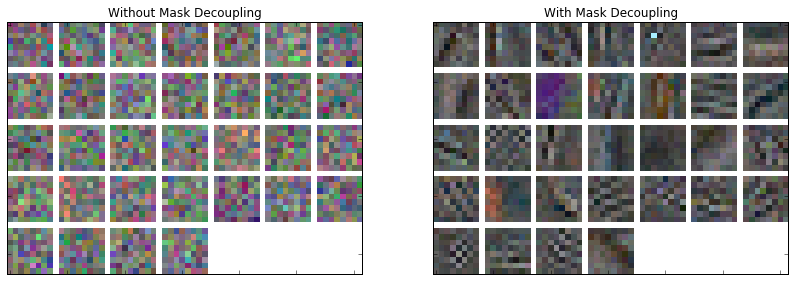

In [10]:
fig = plot.figure(figsize=(14, 7))
plot.subplot(1, 2, 1)
plot.imview(util.tiledict(D1.squeeze()), fgrf=fig,
            title='Without Mask Decoupling')
plot.subplot(1, 2, 2)
plot.imview(util.tiledict(D2.squeeze()), fgrf=fig,
            title='With Mask Decoupling')
fig.show()

Display reference and training images.

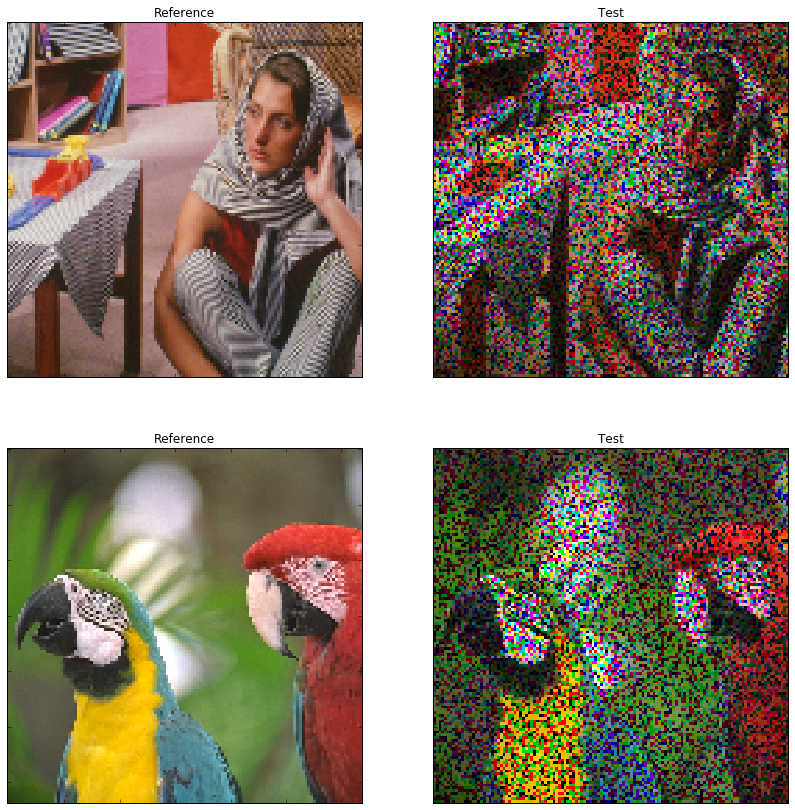

In [11]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(S[...,0], fgrf=fig, title='Reference')
plot.subplot(2, 2, 2)
plot.imview(Sw[...,0], fgrf=fig, title='Test')
plot.subplot(2, 2, 3)
plot.imview(S[...,1], fgrf=fig, title='Reference')
plot.subplot(2, 2, 4)
plot.imview(Sw[...,1], fgrf=fig, title='Test')
fig.show()

Compare reconstructed images.

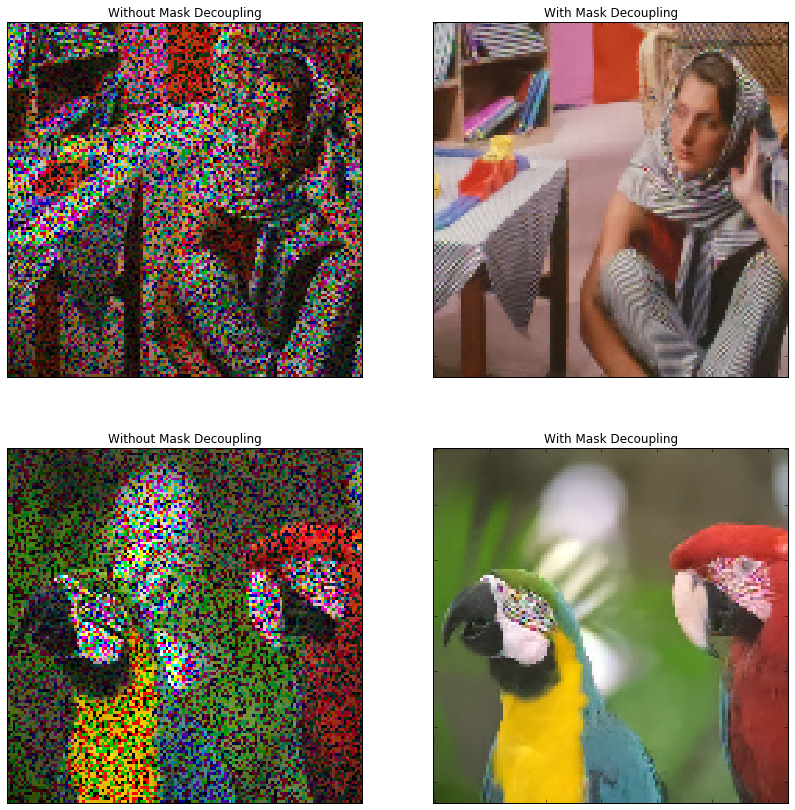

In [12]:
fig = plot.figure(figsize=(14, 14))
plot.subplot(2, 2, 1)
plot.imview(sr1[...,0], fgrf=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 2)
plot.imview(sr2[...,0], fgrf=fig, title='With Mask Decoupling')
plot.subplot(2, 2, 3)
plot.imview(sr1[...,1], fgrf=fig, title='Without Mask Decoupling')
plot.subplot(2, 2, 4)
plot.imview(sr2[...,1], fgrf=fig, title='With Mask Decoupling')
fig.show()